# CMPUT 466/566, Winter 2020 Introduction to Machine learning 
## Coding Assignment 2 
### Problem 1 Report
By Nathan Klapstein #1449872

In [239]:

import struct

import numpy as np

import matplotlib.pyplot as plt
import scipy
import scipy.sparse


Load in the MNIST data for later compute.

In [240]:

def readMNISTdata():
    with open('data/t10k-images-idx3-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        test_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_data = test_data.reshape((size, nrows * ncols))

    with open('data/t10k-labels-idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        test_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_labels = test_labels.reshape((size, 1))

    with open('data/train-images-idx3-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        train_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_data = train_data.reshape((size, nrows * ncols))

    with open('data/train-labels-idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        train_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_labels = train_labels.reshape((size, 1))

    # augmenting a constant feature of 1 (absorbing the bias term)
    train_data = np.concatenate(
        (np.ones([train_data.shape[0], 1]), train_data), axis=1)
    test_data = np.concatenate((np.ones([test_data.shape[0], 1]), test_data),
                               axis=1)
    np.random.seed(314)
    np.random.shuffle(train_labels)
    np.random.seed(314)
    np.random.shuffle(train_data)

    X_train = train_data[:50000] / 256
    t_train = train_labels[:50000]

    X_val = train_data[50000:] / 256
    t_val = train_labels[50000:]

    return X_train, t_train, X_val, t_val, test_data, test_labels


X_train, t_train, X_val, t_val, X_test, t_test = readMNISTdata()

print(X_train.shape, t_train.shape, X_val.shape, t_val.shape, X_test.shape, t_test.shape)


(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)


Various global configurations.

In [282]:
N_class = 10
alpha = 0.4  # learning rate
batch_size = 25000 * 2  # batch size
MaxIter = 35  # Maximum iteration
decay = 0.0  # weight decay
lam = 0.4  # regularization loss multiplier

In [319]:

def oneHotIt(Y):
    """Convert unidimensional array of labels into a one-hot variant
    where the array is size m (examples) x n (classes)."""
    m = Y.shape[0]
    Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX


def softmax(z):
    z -= np.max(z) + np.min(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm


def getLoss(w, x, y):
    m = x.shape[0] #First we get the number of training examples
    y_mat = oneHotIt(y) #Next we convert the integer class coding into a one-hot representation
    scores = np.dot(x,w) #Then we compute raw class scores given our input and current weights
    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(w*w) #We then find the loss of the probabilities
    grad = (-1 / m) * np.dot(x.T, (y_mat - prob)) + lam*w #And compute the gradient for that loss
    return loss, grad


def getProbsAndPreds(someX, w):
    probs = softmax(np.dot(someX, w))
    preds = np.argmax(probs,axis=1)
    return probs,preds


# inspired by https://medium.com/@awjuliani/simple-softmax-in-python-tutorial-d6b4c4ed5c16
# https://www.w3resource.com/numpy/manipulation/ndarray-flatten.php
def getAccuracy(someX, someY, w):
    prob, prede = getProbsAndPreds(someX,w)
    someY = someY.flatten()
    num_correct = np.sum(prede == someY)
    num_incorrect = np.sum(prede != someY)
    accuracy = num_correct/(num_correct+num_incorrect)
    return accuracy, num_correct, num_incorrect


def predict(x, w, t=None):
    # X_new: Nsample x (d+1)
    # W: (d+1) x K
    
    # TODO Your code here
    y = np.matmul(x, w)
    
    t_hat = np.argmax(y, axis=1)
    
    m = x.shape[0] #First we get the number of training examples
    y_mat = oneHotIt(t) #Next we convert the integer class coding into a one-hot representation
    scores = np.dot(x,w) #Then we compute raw class scores given our input and current weights
    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(w*w) # compute the loss
    
    # compute the mean-per class accuracy
    acc = getAccuracy(x, t, w)
    
    return y, t_hat, loss, acc


def train(X_train, t_train, X_val, t_val):
    N_train = X_train.shape[0]
    N_val = X_val.shape[0]

    # TODO Your code here
    
    # initialization
    w = np.zeros([X_train.shape[1], N_class])
    # w: (d+1)x1

    losses_train = []
    acc_val = []
    w_best = None
    acc_best = 0
    epoch_best = 0
    
    print(f"running {int(np.ceil(N_train / batch_size))} batches of size {batch_size} over data size {X_train.shape[0]} for {MaxIter} epochs")
    for epoch in range(MaxIter):
        loss_this_epoch = 0
        for b in range(int(np.ceil(N_train / batch_size))):
            X_batch = X_train[b * batch_size: (b + 1) * batch_size]
            t_batch = t_train[b * batch_size: (b + 1) * batch_size]
            loss_batch, grad = getLoss(w, X_batch, t_batch)
            loss_this_epoch += loss_batch
            
            # gradient decent with simple weight decay
            w = w - (alpha * grad) - (alpha * decay * w)
   
        # TODO: Your code here
        # monitor model behavior after each epoch
        
        # 1. Compute the training loss by averaging loss_this_epoch    
        loss_this_epoch = loss_this_epoch / (int(np.ceil(N_train/batch_size)))
        val_acc, num_correct, num_incorrect = getAccuracy(X_val, t_val, w)
        print(f"epoch {epoch:>3}/{MaxIter:<2} loss:{loss_this_epoch:.18f} val_acc:{val_acc:.6f} correct|incorrect:{num_correct}|{num_incorrect}")
        losses_train.append(loss_this_epoch)

        # 2. Perform validation on the validation test by the risk
        # TODO: FIXED: Validation set should not be run in batches
        acc_val.append(val_acc)
        
        # 3. Keep track of the best validation epoch, risk, and the weights
        if acc_val[epoch] >= acc_best:
            epoch_best = epoch
            acc_best = acc_val[epoch]
            w_best = w

    # Return some variables as needed
    return epoch_best, losses_train, acc_val, acc_best, w_best


def plot_training_losses(losses_train):
    fig = plt.figure()
    plt.plot(losses_train, label="Training Losses")
    plt.title("Training Losses")
    plt.legend()
    plt.xlabel('Number of epoch')
    plt.ylabel('Training Loss')
    plt.show()
    
    
def plot_training_accuracy(acc_val):
    fig = plt.figure()
    plt.plot(acc_val, label="Validation Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.xlabel('Number of epoch')
    plt.ylabel('Validation Accuracy')
    plt.show()
    

In [313]:

epoch_best, losses_train, acc_val, acc_best, W_best = train(X_train, t_train, X_val, t_val)

print(f"best epoch: {epoch_best} acc:{acc_best:.6f}")


running 1 batches of size 50000 over data size 50000 for 35 epochs
epoch   0/35 loss:2.302585092994044125 val_acc:0.665000 correct|incorrect:6650|3350
epoch   1/35 loss:1.951664044804228837 val_acc:0.771900 correct|incorrect:7719|2281
epoch   2/35 loss:1.779179502292060677 val_acc:0.771400 correct|incorrect:7714|2286
epoch   3/35 loss:1.695926021288843621 val_acc:0.792800 correct|incorrect:7928|2072
epoch   4/35 loss:1.655109847757574748 val_acc:0.794700 correct|incorrect:7947|2053
epoch   5/35 loss:1.634609043409839479 val_acc:0.802600 correct|incorrect:8026|1974
epoch   6/35 loss:1.624113141115669068 val_acc:0.805100 correct|incorrect:8051|1949
epoch   7/35 loss:1.618603251584766145 val_acc:0.808700 correct|incorrect:8087|1913
epoch   8/35 loss:1.615654251454750501 val_acc:0.810400 correct|incorrect:8104|1896
epoch   9/35 loss:1.614039091419714467 val_acc:0.812500 correct|incorrect:8125|1875
epoch  10/35 loss:1.613137331664936003 val_acc:0.813500 correct|incorrect:8135|1865
epoch  11

The learning curve of the training loss, where x-axis is the number of epochs,
and y-axis is the training loss.

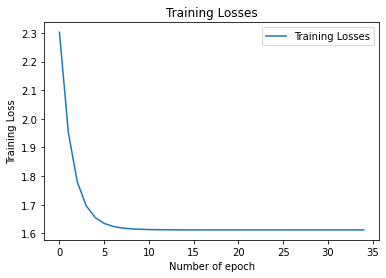

In [320]:
plot_training_losses(losses_train)

The accuracy curve, where x-axis is the number of epochs, and y-axis is the 
accuracy in decimal form (0.0-1.0).

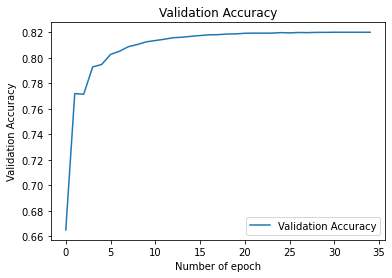

In [321]:
plot_training_accuracy(acc_val)

Getting accuracy of the learned model on the test set.

In [317]:

acc_test, num_correct, num_incorrect = getAccuracy(X_test, t_test, W_best)
print(f"tst_acc:{acc_test:.6f} correct|incorrect:{num_correct}|{num_incorrect}")


tst_acc:0.830000 correct|incorrect:8300|1700


c:\users\nathan\pycharmprojects\cmput_466_coding_assignment_2\.venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
c:\users\nathan\pycharmprojects\cmput_466_coding_assignment_2\.venv\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


### Problem 2 Report

Ask one meaningful scientific question yourself, design your experimental 
protocol, present results, and draw a conclusion.  

#### Scientific Question

With proper tailoring of the configuration variables:

* ``alpha`` - learning rate
* ``batch_size`` -  batch size
* ``MaxIter`` - number of epochs
* ``decay`` - weight decay
* ``lam`` - regularization loss multiplier

Can we obtain a accuracy better than 83% 83% on the test set?

If so what is the most efficient method of maximizing accuracy performance 
given these configurations?

#### Experimental Protocol
 

#### Experimental Results

#### Conclusion